In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Standard library imports
import json
import logging
import os
import random
import sys
import time
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Optional, Tuple, Union
import warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Graphs and networks
import networkx as nx
import igraph as ig
import scipy.sparse as sparse

# Scientific computing
import math
from scipy.interpolate import CubicSpline, interp1d
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex, to_rgb
from mpl_toolkits.mplot3d import Axes3D

# Data visualization and processing
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

# Performance optimization
from numba import jit, prange

# Progress bars
from tqdm.notebook import tqdm

# Custom modules
from bundling3D import *
from fa2_modified import ForceAtlas2

# Set Seaborn style for plots
sns.set_style("white")

In [3]:
# 2. Constants and configuration
INPUT_GRAPH_PATH = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
CLUSTER_INFO_LABEL_TREE = "../output/cluster-qualifications/ClusterInfoLabelTree.xlsx"
CLUSTER_LABEL_DICT_PATH = "../data/99-testdata/cluster_label_dict.json"
CLUSTER_TREE_PATH = "../output/cluster-qualifications/ClusterHierachy_noComments.json"
OUTPUT_DIR = "../data/99-testdata/"
THREEJS_OUTPUT_DIR = (
    "/Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/"
)
CLUSTER_HIERACHY_FOR_LEGEND_PATH = (
    "../output/cluster-qualifications/ClusterHierachy_noComments.json"
)

# Classes


## Utility functions


In [4]:
class GraphDataFrameUtility:
    """
    A utility class for converting igraph graph attributes to pandas DataFrames
    and performing DataFrame operations related to graph data.
    """

    @staticmethod
    def edges_to_dataframe(g: ig.Graph) -> pd.DataFrame:
        """
        Convert the edges and their attributes of an igraph graph to a pandas DataFrame.

        Args:
            g (ig.Graph): The input igraph graph.

        Returns:
            pd.DataFrame: A DataFrame containing edge attributes, source, and target nodes.
        """
        # check if networkx or igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        # Extract edge attributes
        edge_data = {attr: g.es[attr] for attr in g.es.attributes()}

        # Add source and target node indices
        edge_data["source"] = [e.source for e in g.es]
        edge_data["target"] = [e.target for e in g.es]

        # Convert to DataFrame
        edge_dataframe = pd.DataFrame(edge_data)

        return edge_dataframe

    @staticmethod
    def nodes_to_dataframe(
        g: ig.Graph, drop_columns: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """
        Convert the nodes and their attributes of an igraph graph to a pandas DataFrame.

        Args:
            g (ig.Graph): The input igraph graph.
            drop_columns (Optional[List[str]]): A list of column names to drop from the DataFrame.

        Returns:
            pd.DataFrame: A DataFrame containing node attributes and node indices.
        """
        # check if networkx or igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        # Extract node attributes
        node_data = {attr: g.vs[attr] for attr in g.vs.attributes()}

        # Add node indices
        node_dataframe = pd.DataFrame(node_data)
        node_dataframe["node_index"] = [n.index for n in g.vs]
        # Calculate min/max for coordinates
        xmin, xmax = np.min(node_dataframe["x"]), np.max(node_dataframe["x"])
        ymin, ymax = np.min(node_dataframe["y"]), np.max(node_dataframe["y"])
        zmin, zmax = np.min(node_dataframe["z"]), np.max(node_dataframe["z"])

        # Normalize coordinates
        node_dataframe["x"] = minmax_normalize(node_dataframe["x"], xmin, xmax)
        node_dataframe["y"] = minmax_normalize(node_dataframe["y"], ymin, ymax)
        node_dataframe["z"] = minmax_normalize(node_dataframe["z"], zmin, zmax)

        print("Coordinates normalized to [0, 1] range.")

        # Drop specified columns if provided
        if drop_columns:
            node_dataframe = node_dataframe.drop(columns=drop_columns, errors="ignore")

        return node_dataframe

    @staticmethod
    def merge_edge_node_positions(
        edge_dataframe: pd.DataFrame, node_dataframe: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Merge the edge DataFrame with node positions (x, y, z) for source and target nodes.

        Args:
            edge_dataframe (pd.DataFrame): DataFrame containing edge information.
            node_dataframe (pd.DataFrame): DataFrame containing node positions and other attributes.

        Returns:
            pd.DataFrame: A merged DataFrame with source and target node positions, cleaned and indexed.
        """
        # Merge edge DataFrame with source node positions
        edge_node_pos_df = pd.merge(
            edge_dataframe,
            node_dataframe[["x", "y", "z"]],
            left_on="source",
            right_index=True,
        )
        edge_node_pos_df = edge_node_pos_df.rename(
            columns={"x": "source_x", "y": "source_y", "z": "source_z"}
        )

        # Merge with target node positions
        edge_node_pos_df = pd.merge(
            edge_node_pos_df,
            node_dataframe[["x", "y", "z"]],
            left_on="target",
            right_index=True,
        )
        edge_node_pos_df = edge_node_pos_df.rename(
            columns={"x": "target_x", "y": "target_y", "z": "target_z"}
        )

        # Print shape before and after dropping NaNs
        print(f"Shape before dropping NaNs: {edge_node_pos_df.shape}")

        # Drop rows with any NaN values
        edge_node_pos_df.dropna(inplace=True)

        # Sort and reset the index
        edge_node_pos_df = edge_node_pos_df.sort_index().reset_index(drop=True)

        print(f"Shape after cleaning: {edge_node_pos_df.shape}")

        # calculate segment_lenths of all edges

        edge_node_pos_df["segment_length"] = [
            distance_between(x[:3], x[3:])
            for x in edge_node_pos_df[
                ["source_x", "source_y", "source_z", "target_x", "target_y", "target_z"]
            ].values
        ]

        edge_node_pos_df = edge_node_pos_df[edge_node_pos_df["segment_length"] > 0]

        edge_node_pos_df[["source", "target"]] = (
            edge_node_pos_df[["source", "target"]]
            .stack()
            .rank(method="dense")
            .unstack()
            .astype(int)
        )

        # Print min, max, and mean segment lengths
        print("Segment length statistics:")
        print(f"Min: {edge_node_pos_df['segment_length'].min()}")
        print(f"Max: {edge_node_pos_df['segment_length'].max()}")
        print(f"Mean: {edge_node_pos_df['segment_length'].mean()}")
        print(f"Median: {edge_node_pos_df['segment_length'].median()}")

        return edge_node_pos_df

## Graph reader


In [5]:
class GraphReader:
    @staticmethod
    def read_and_clean_graph(path: str) -> ig.Graph:
        g = ig.Graph.Read_GraphML(path)
        g.vs["node_id"] = [int(i) for i in range(g.vcount())]

        if "id" in g.vs.attribute_names():
            g.vs["node_name"] = g.vs["id"]
            del g.vs["id"]

        if "cluster" in g.vs.attribute_names():
            g.vs["cluster"] = [int(cluster) for cluster in g.vs["cluster"]]

        if "year" in g.vs.attribute_names():
            g.vs["year"] = [int(year) for year in g.vs["year"]]

        if "eid" in g.vs.attribute_names():
            del g.vs["eid"]

        if "centrality_alpha0.3_k10_res0.006" in g.vs.attribute_names():
            del g.vs["centrality_alpha0.3_k10_res0.006"]

        if "centrality_alpha0.3_k10_res0.002" in g.vs.attribute_names():
            g.vs["centrality"] = g.vs["centrality_alpha0.3_k10_res0.002"]
            del g.vs["centrality_alpha0.3_k10_res0.002"]

        g.es["edge_id"] = list(range(g.ecount()))
        print("Node Attributes:", g.vs.attribute_names())
        print("Edge Attributes:", g.es.attribute_names())
        # print number of nodes and edges
        print(f"Number of nodes: {g.vcount()}")
        print(f"Number of edges: {g.ecount()}")
        return g

    @staticmethod
    def subgraph_of_clusters(G, clusters):
        if isinstance(G, nx.Graph):
            nodes = [
                node for node in G.nodes if G.nodes[node].get("cluster") in clusters
            ]
            return G.subgraph(nodes)
        elif isinstance(G, ig.Graph):
            nodes = [v.index for v in G.vs if v["cluster"] in clusters]
            return G.subgraph(nodes)
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

    @staticmethod
    def add_cluster_labels(
        G: Union[nx.Graph, ig.Graph],
        labels_file_path: str = "../output/cluster-qualifications/raw_cluster_labels.json",
    ) -> Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
        """
        Add cluster labels to the graph nodes.

        Args:
            G (Union[nx.Graph, ig.Graph]): The input graph (NetworkX or igraph).
            labels_file_path (str): Path to the JSON file containing cluster labels.

        Returns:
            Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
                The graph with added cluster labels and the cluster label dictionary.
        """
        with open(labels_file_path) as file:
            cluster_label_dict = json.load(file)
        cluster_label_dict = {float(k): v[0] for k, v in cluster_label_dict.items()}

        if isinstance(G, nx.Graph):
            for node in G.nodes:
                cluster = G.nodes[node]["cluster"]
                G.nodes[node]["cluster_label"] = cluster_label_dict.get(
                    cluster, "Unknown"
                )
        elif isinstance(G, ig.Graph):
            G.vs["cluster_label"] = [
                cluster_label_dict.get(v["cluster"], "Unknown") for v in G.vs
            ]
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

        return G, cluster_label_dict

## Layout Utilities (Fruchterman-Reingold)


In [6]:
import time
import networkx as nx
import igraph as ig
from typing import Union, Dict, Tuple, Optional


class LayoutUtility:
    """
    Layout utility class for igraph layout operations. made for fruchterman-reingold layout.

    Args:
        g (Union[nx.Graph, ig.Graph]): The input graph (NetworkX or igraph).
        layout_params (Optional[Dict]): The layout parameters.

    Returns:
        Tuple[nx.Graph, Dict]: The graph with assigned coordinates and the layout dictionary.
    """

    @staticmethod
    def fr_layout_nx(
        g: Union[nx.Graph, ig.Graph], layout_params: Optional[Dict] = None
    ) -> Tuple[nx.Graph, Dict]:
        print("Starting Fruchterman-Reingold layout process...")
        start_time = time.time()

        if layout_params is None:
            layout_params = {
                "iterations": 100,
                "threshold": 0.00001,
                "weight": "weight",
                "scale": 1,
                "center": (0, 0),
                "dim": 2,
                "seed": 1887,
            }
        print(f"Layout parameters: {layout_params}")

        if not isinstance(g, nx.Graph):
            print("Converting to NetworkX Graph...")
            G = g.to_networkx()
            print("Conversion complete.")
        else:
            G = g

        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

        print("Calculating layout...")
        layout_start_time = time.time()
        pos = nx.spring_layout(G, **layout_params)
        layout_end_time = time.time()
        print(
            f"Layout calculation completed in {layout_end_time - layout_start_time:.2f} seconds."
        )

        print("Processing layout results...")
        node_xy_dict = {node: pos[node] for node in G.nodes}

        x_values, y_values = zip(*node_xy_dict.values())
        min_x, max_x = min(x_values), max(x_values)
        min_y, max_y = min(y_values), max(y_values)

        print(f"Layout boundaries:")
        print(f"X-axis: Min = {min_x:.2f}, Max = {max_x:.2f}")
        print(f"Y-axis: Min = {min_y:.2f}, Max = {max_y:.2f}")

        print("Assigning coordinates to nodes...")
        for node in G.nodes:
            G.nodes[node]["x"] = node_xy_dict[node][0]
            G.nodes[node]["y"] = node_xy_dict[node][1]

        end_time = time.time()
        total_time = end_time - start_time
        print(f"Layout process completed in {total_time:.2f} seconds.")

        return G, pos


# Usage example:
# g = ... # your graph object
# G, pos = LayoutUtility.fr_layout_nx(g)

### Add z coordinates to the nodes


In [7]:
class ZCoordinateAdder:
    def __init__(self, g, scale_factor=0.15):
        self.g = g
        self.scale_factor = scale_factor

    def add_z_coordinate_to_nodes(self):
        """
        Add a z-coordinate to the nodes of the graph based on their centrality values.

        Args:
            g (nx.Graph): The input graph.
            scale_factor (float): The scaling factor for the z-coordinates. (they should not be as spread out as x and y)

        Returns:
            nx.Graph: The graph with the z-coordinate added to the nodes.
        """
        # Calculate the bounds of x and y coordinates
        # Assuming self.g is a NetworkX graph
        xvalues = [attributes["x"] for _, attributes in self.g.nodes(data=True)]
        yvalues = [attributes["y"] for _, attributes in self.g.nodes(data=True)]
        min_x, max_x = min(xvalues), max(xvalues)
        min_y, max_y = min(yvalues), max(yvalues)

        print("Bounds of the layout:")
        print(f"Min x: {min_x}, Max x: {max_x}")
        print(f"Min y: {min_y}, Max y: {max_y}")

        # Extract centrality values from nodes
        centralities = np.array(
            [self.g.nodes[node]["centrality"] for node in self.g.nodes]
        )

        # Normalize centrality values to range [0, 1]
        centrality_min = centralities.min()
        centrality_max = centralities.max()
        centralities_normalized = (centralities - centrality_min) / (
            centrality_max - centrality_min
        )

        # Adjust normalized centrality values to range [-1, 1]
        centralities_adjusted = centralities_normalized * 2 - 1

        # Scale down the z-values to make them less pronounced
        z_coordinates = centralities_adjusted * self.scale_factor

        # Add z-coordinate to nodes
        for i, node in enumerate(self.g.nodes):
            self.g.nodes[node]["z"] = z_coordinates[i]

        # Describe the distribution of z values
        print("Description of the Z coordinate values:")
        print(pd.Series(z_coordinates).describe())

        print("Z coordinate added to nodes")
        return self.g

# Prune edges


In [8]:
import igraph as ig
import numpy as np
import random
from typing import Dict


class PruneEdges:
    """
    A class for pruning edges in a graph based on specific criteria, such as edge weight percentiles or random selection.
    """

    def __init__(self):
        self.initial_edge_count = 0
        self.initial_isolates = 0
        self.final_edge_count = 0
        self.final_isolates = 0

    def _update_statistics(self, g: ig.Graph, g_modified: ig.Graph) -> None:
        """
        Update class attributes related to graph statistics.

        Args:
            g (ig.Graph): The original graph.
            g_modified (ig.Graph): The modified graph after pruning or random selection.
        """
        self.initial_edge_count = g.ecount()
        self.initial_isolates = len(g.vs.select(_degree=0))
        self.final_edge_count = g_modified.ecount()
        self.final_isolates = len(g_modified.vs.select(_degree=0))

    def prune_edges_by_percentile_weight(
        self, g: ig.Graph, percentile: float
    ) -> ig.Graph:
        """
        Remove edges from the graph that have weight less than or equal to the specified percentile weight.

        Args:
            g (ig.Graph): The input graph. Must have a 'weight' attribute for edges.
            percentile (float): The percentile to use as the threshold for pruning edges.

        Returns:
            ig.Graph: A new graph with edges removed based on the specified percentile.

        Raises:
            ValueError: If the input graph has no 'weight' attribute for edges.
            ValueError: If percentile is not between 0 and 100.
        """
        if not (0 <= percentile <= 100):
            raise ValueError("Percentile must be between 0 and 100.")

        if "weight" not in g.es.attributes():
            raise ValueError("Input graph must have a 'weight' attribute for edges.")

        # Get all weights and calculate the specified percentile
        weights = g.es["weight"]
        weight_threshold = np.percentile(weights, percentile)

        # Identify edges to keep
        edges_to_keep = [
            edge.index for edge in g.es if edge["weight"] > weight_threshold
        ]
        threshold_edges = [
            edge.index for edge in g.es if edge["weight"] == weight_threshold
        ]

        # Randomly select from threshold edges to reach target number of edges
        target_edge_count = int(self.initial_edge_count * (1 - percentile / 100))
        edges_to_add = target_edge_count - len(edges_to_keep)
        if edges_to_add > 0:
            random.shuffle(threshold_edges)
            edges_to_keep.extend(threshold_edges[:edges_to_add])

        # Create a new graph with only the selected edges
        g_pruned = g.subgraph_edges(edges_to_keep, delete_vertices=False)

        # Update statistics
        self._update_statistics(g, g_pruned)

        return g_pruned

    def keep_random_percentile_of_edges(
        self, g: ig.Graph, percentile: float
    ) -> ig.Graph:
        """
        Keep a random selection of edges based on the provided percentile.

        Args:
            g (ig.Graph): The input graph.
            percentile (float): The percentile of edges to keep (0-100).

        Returns:
            ig.Graph: A new graph with the randomly selected edges.

        Raises:
            ValueError: If percentile is not between 0 and 100.
        """
        if not (0 <= percentile <= 100):
            raise ValueError("percentile must be between 0 and 100.")

        # Calculate the number of edges to keep
        total_edges = g.ecount()
        num_edges_to_keep = int(total_edges * (percentile / 100))

        # Randomly select edges to keep
        all_edges = list(range(total_edges))
        random.shuffle(all_edges)
        edges_to_keep = all_edges[:num_edges_to_keep]

        # Create a new graph with only the selected edges
        g_random = g.subgraph_edges(edges_to_keep, delete_vertices=False)

        # Update statistics
        self._update_statistics(g, g_random)

        return g_random

    def get_prune_summary(self) -> Dict[str, int]:
        """
        Returns a summary of the pruning process.

        Returns:
            Dict[str, int]: A dictionary containing the initial and final edge counts and the number of isolates.
        """
        return {
            "initial_edge_count": self.initial_edge_count,
            "final_edge_count": self.final_edge_count,
            "initial_isolates": self.initial_isolates,
            "final_isolates": self.final_isolates,
        }


# example usage
# g = ... # your graph object
# pruner = PruneEdges()
# g_pruned = pruner.prune_edges_by_percentile_weight(g, 10)
# summary = pruner.get_prune_summary()

## Nodes Saver


In [9]:
class NodesSaver:
    """
    A utility class for saving graph data to JSON format, particularly for use in JavaScript applications.
    """

    @staticmethod
    def save_igraph_nodes_to_json(
        g: ig.Graph,
        paths: Union[str, List[str]],
        return_json: bool = False,
        attributes: List[str] = None,
    ) -> Optional[List[Dict]]:
        """
        Save the igraph nodes to one or more JSON files.
        Args:
            g (ig.Graph): The input graph.
            paths (Union[str, List[str]]): Path or list of paths to save the JSON file(s).
            return_json (bool): If True, return the JSON data as well as saving it.
            attributes (List[str]): List of node attributes to include in the JSON.
        Returns:
            Optional[List[Dict]]: List of node dictionaries if return_json is True, else None.
        Raises:
            ValueError: If a specified attribute is missing from a node.
        """
        if attributes is None:
            attributes = [
                "node_id",
                "node_name",
                "doi",
                "year",
                "title",
                "cluster",
                "centrality",
                "x",
                "y",
                "z",
            ]

        # Fix encoding of titles
        g.vs["title"] = [NodesSaver.fix_encoding(title) for title in g.vs["title"]]

        nodes_json = []
        for node in g.vs:
            if not all(attr in node.attributes() for attr in attributes):
                raise ValueError(f"Missing attribute in node: {node.attributes()}")
            node_dict = {attr: node[attr] for attr in attributes}
            nodes_json.append(node_dict)

        # Convert single path to list for consistent processing
        if isinstance(paths, str):
            paths = [paths]

        # Save to all specified paths
        for path in paths:
            with open(path, "w") as f:
                json.dump(nodes_json, f)
            print(f"Graph nodes saved to {path}")

        return nodes_json if return_json else None

    @staticmethod
    def fix_encoding(title: str) -> str:
        """
        Fix the encoding of a string.
        Args:
            title (str): The input string to fix.
        Returns:
            str: The fixed string.
        """
        try:
            decoded_title = title.encode("utf-8").decode("unicode_escape")
            return decoded_title.encode("latin1").decode("utf-8")
        except UnicodeEncodeError:
            # If the above method fails, return the original title
            return title

# Start the algorithm


## read and layout the graph


In [10]:
# g = GraphReader.read_and_clean_graph(INPUT_GRAPH_PATH)
g = GraphReader.read_and_clean_graph(
    "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/intermediate_graph_bundled_clusters0to100.graphml"
)
cluster_list = list(range(39, 50))

# subset to only cluster 0 to 100
g = GraphReader.subgraph_of_clusters(g, cluster_list)

total_nodes = len(g.vs)
################################################################################################
layout_params = {
    # "k": 0.5, # distance between nodes; best to leave it to algo
    "iterations": 20,  # (default=50) use 100
    "threshold": 0.0001,  # default 0.0001
    "weight": "weight",
    "scale": 1,
    "center": (0, 0),
    "dim": 2,
    "seed": 1887,
}

g_fr, pos = LayoutUtility.fr_layout_nx(g, layout_params)

print("#" * 100)
print("Layout done")
print("#" * 100)

################################################################################################

# Add z-coordinate to nodes based on centrality
z_adder = ZCoordinateAdder(g_fr, scale_factor=0.15)
g_z = z_adder.add_z_coordinate_to_nodes()

print("#" * 100)
print("Z coordinate added to nodes")
print("#" * 100)

Node Attributes: ['_nx_name', 'doi', 'year', 'title', 'cluster', 'node_id', 'node_name', 'centrality', 'x', 'y', 'z']
Edge Attributes: ['edge_id', 'weight']
Number of nodes: 37804
Number of edges: 112849
Starting Fruchterman-Reingold layout process...
Layout parameters: {'iterations': 20, 'threshold': 0.0001, 'weight': 'weight', 'scale': 1, 'center': (0, 0), 'dim': 2, 'seed': 1887}
Converting to NetworkX Graph...
Conversion complete.
Graph has 3792 nodes and 10941 edges.
Calculating layout...
Layout calculation completed in 12.07 seconds.
Processing layout results...
Layout boundaries:
X-axis: Min = -0.99, Max = 1.00
Y-axis: Min = -1.00, Max = 0.98
Assigning coordinates to nodes...
Layout process completed in 12.79 seconds.
####################################################################################################
Layout done
####################################################################################################
Bounds of the layout:
Min x: -0.990547239780426, Max

## Prune


In [11]:
################################################################################################
# prune edges
pruning_weight_percentile = 50
pruner = PruneEdges()
g_pruned_weight = pruner.prune_edges_by_percentile_weight(g, pruning_weight_percentile)
summary = pruner.get_prune_summary()
print(summary)

# random percentage of edges
pruning_random_percentile = 50
pruner = PruneEdges()
g_pruned_random = pruner.keep_random_percentile_of_edges(g, pruning_random_percentile)
summary = pruner.get_prune_summary()
print(summary)
print("#" * 100)

{'initial_edge_count': 10941, 'final_edge_count': 5470, 'initial_isolates': 685, 'final_isolates': 1179}
{'initial_edge_count': 10941, 'final_edge_count': 8205, 'initial_isolates': 685, 'final_isolates': 833}
####################################################################################################


## Dataframe conversion


In [12]:
# Assume `g` is an igraph.Graph object and you have the utility class imported.
edges_df = GraphDataFrameUtility.edges_to_dataframe(g_pruned_random)
# Create edge and node DataFrames
nodes_df = GraphDataFrameUtility.nodes_to_dataframe(
    g_pruned_random, drop_columns=["_nx_name", "node_name"]
)

# Merge edge and node positions
all_coords_edge_df = GraphDataFrameUtility.merge_edge_node_positions(edges_df, nodes_df)

Coordinates normalized to [0, 1] range.
Shape before dropping NaNs: (8205, 10)
Shape after cleaning: (8205, 10)
Segment length statistics:
Min: 0.004206821137500441
Max: 0.983849412649517
Mean: 0.223738389478224
Median: 0.15884537152081998


In [13]:
nodes_df.head(2)

,doi,year,title,cluster,node_id,centrality,x,y,z,node_index
0,,1982,Treatment of intention myoclonus with paroxeti...,41,2,0.039863,0.784951,0.378091,0.039233,0
1,10.1111/j.1600-0404.1982.tb04525.x,1982,Treatment of myoclonic syndromes with paroxeti...,41,4,0.053676,0.732362,0.524226,0.053055,1


In [14]:
edges_df.head(2)

,edge_id,weight,source,target
0,2,0.663864,0,1
1,82,0.795334,4,14


In [15]:
all_coords_edge_df.head(2)

,edge_id,weight,source,target,source_x,source_y,source_z,target_x,target_y,target_z,segment_length
0,2,0.663864,1,2,0.784951,0.378091,0.039233,0.732362,0.524226,0.053055,0.155923
1,82,0.795334,4,9,0.495683,0.871647,0.098976,0.475381,0.922010,0.033970,0.084701


## quick check


(3792, 3792)


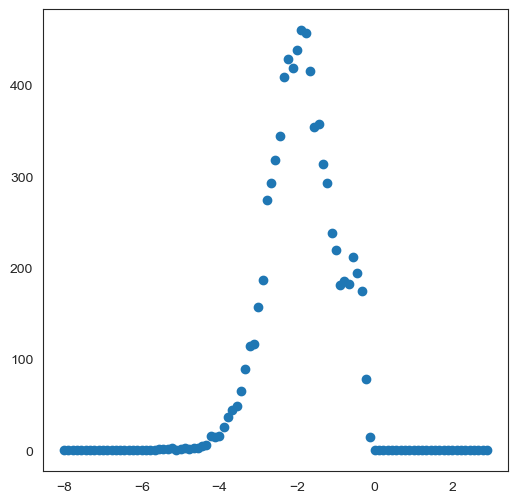

In [16]:
Nnodes = nodes_df.shape[0]

subedges = all_coords_edge_df["segment_length"] > 0.03

mat = sparse.coo_matrix(
    (
        np.ones(all_coords_edge_df.loc[subedges].shape[0], dtype=int),
        (
            all_coords_edge_df.loc[subedges, "source"].values,
            all_coords_edge_df.loc[subedges, "target"].values,
        ),
    ),
    shape=(Nnodes, Nnodes),
)

print(mat.shape)

ncomp, membership = sparse.csgraph.connected_components(mat)

mvalue, mcounts = np.unique(membership, return_counts=True)
mcounts, mcountdist = np.unique(mcounts, return_counts=True)

mcounts, mcountdist

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

dist, bins = np.histogram(
    all_coords_edge_df["segment_length"].values, bins=np.exp(np.linspace(-8, 3, 100))
)

ax.scatter(np.log(bins[:-1]), dist)

plt.show()

# BUNDLE


## Set Threshold for Edge Length


In [17]:
# get edges to bundle above a certain threshold
# threshold = 0.03
threshold = 0.15807877788821245
edges_to_bundle = all_coords_edge_df["segment_length"] > threshold
edges_to_bundle_df = all_coords_edge_df.loc[edges_to_bundle].reset_index(drop=True)
print(f"Edges to bundle: {edges_to_bundle.sum()}")

Edges to bundle: 4124


## Bundling


In [18]:
bundled_edge_pts = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_to_bundle_df[["source", "target"]],
    initial_bandwidth=0.40,
    decay=0.7,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.001,
    max_segment_length=0.05,
)
bundled_edge_pts.head()

Process Bundling
Start Bundling


## Post Bundling Processing

add source and target columns, create clean df and save it


In [ ]:
def createBundledEdgesDf(bundled_edge_pts, edges_to_bundle_df):
    sub_bundle_idx = 0
    x, y, z = [], [], []
    bundled_edges_dict = {}
    for i in range(len(bundled_edge_pts)):
        # if not nan
        if pd.isna(bundled_edge_pts.iloc[i, 0]):
            target = edges_to_bundle_df.loc[sub_bundle_idx, "target"]
            source = edges_to_bundle_df.loc[sub_bundle_idx, "source"]
            bundled_edges_dict[(source, target)] = {
                "x": x,
                "y": y,
                "z": z,
            }
            sub_bundle_idx += 1
            x, y, z = [], [], []
        else:
            x.append(bundled_edge_pts.iloc[i, 0])
            y.append(bundled_edge_pts.iloc[i, 1])
            z.append(bundled_edge_pts.iloc[i, 2])

    # create df
    bundled_edges_df = pd.DataFrame.from_dict(bundled_edges_dict, orient="index")
    bundled_edges_df["source"] = [x[0] for x in bundled_edges_df.index]
    bundled_edges_df["target"] = [x[1] for x in bundled_edges_df.index]
    bundled_edges_df.reset_index(drop=True, inplace=True)
    print(f"Number of bundled edges: {bundled_edges_df.shape[0]}")
    return bundled_edges_df


def createStraightEdgesDf(all_coords_edge_df, threshold):
    straight_edges_mask = all_coords_edge_df["segment_length"] <= threshold

    straight_edges_df = all_coords_edge_df.loc[
        straight_edges_mask,
        [
            "source",
            "target",
            "source_x",
            "source_y",
            "source_z",
            "target_x",
            "target_y",
            "target_z",
        ],
    ].reset_index(drop=True)

    straight_edges_df["x"] = [
        [source_x, target_x]
        for source_x, target_x in zip(
            straight_edges_df["source_x"], straight_edges_df["target_x"]
        )
    ]
    straight_edges_df["y"] = [
        [source_y, target_y]
        for source_y, target_y in zip(
            straight_edges_df["source_y"], straight_edges_df["target_y"]
        )
    ]
    straight_edges_df["z"] = [
        [source_z, target_z]
        for source_z, target_z in zip(
            straight_edges_df["source_z"], straight_edges_df["target_z"]
        )
    ]

    # Drop coordinate columns
    straight_edges_df = straight_edges_df.drop(
        columns=["source_x", "source_y", "source_z", "target_x", "target_y", "target_z"]
    )

    return straight_edges_df


bundled_edges_df = createBundledEdgesDf(bundled_edge_pts, edges_to_bundle_df)
straight_edges_df = createStraightEdgesDf(all_coords_edge_df, threshold)

print(f"Number of straight edges: {straight_edges_df.shape[0]}")
# Concatenate bundled and straight edges
final_edges_df = pd.concat([bundled_edges_df, straight_edges_df], ignore_index=True)

# round to 10 decimal places in x,y,z
final_edges_df["x"] = final_edges_df["x"].apply(lambda x: [round(i, 10) for i in x])
final_edges_df["y"] = final_edges_df["y"].apply(lambda x: [round(i, 10) for i in x])
final_edges_df["z"] = final_edges_df["z"].apply(lambda x: [round(i, 10) for i in x])

print(f"Number of total edges: {final_edges_df.shape[0]}")

Number of bundled edges: 4104
Number of straight edges: 4101
Number of total edges: 8205


# SAVER


In [ ]:
def add_color_attr(edges_df, nodes_df):
    # Add cluster to nr or -1 if not in same cluster
    color = []
    for source, target in zip(edges_df["source"], edges_df["target"]):
        if nodes_df.loc[source, "cluster"] == nodes_df.loc[target, "cluster"]:
            color.append(nodes_df.loc[source, "cluster"])
        else:
            color.append(-1)
    edges_df["color"] = color
    return edges_df


def transform_edges(
    edges_df, x_col="x", y_col="y", z_col="z", extra_edge_attributes=None
):
    """
    Transform edge data from a DataFrame into a list of dictionaries with points and extra attributes.

    Args:
    edges_df (pd.DataFrame): DataFrame containing edge data.
    x_col (str): Name of the column containing x-coordinates. Default is "x".
    y_col (str): Name of the column containing y-coordinates. Default is "y".
    z_col (str): Name of the column containing z-coordinates. Default is "z".
    extra_edge_attributes (list): List of additional attribute names to include. Default is None.

    Returns:
    list: A list of dictionaries, each representing an edge with its points and attributes.
    """
    if extra_edge_attributes is None:
        extra_edge_attributes = []

    def create_edge_object(edge):
        return {
            **{attr: edge[attr] for attr in extra_edge_attributes if attr in edge},
            "points": [
                {"x": float(x), "y": float(y), "z": float(z)}
                for x, y, z in zip(edge[x_col], edge[y_col], edge[z_col])
                if not (pd.isna(x) or pd.isna(y) or pd.isna(z))
            ],
        }

    return [create_edge_object(edge) for edge in edges_df.to_dict(orient="records")]


edges_df = add_color_attr(final_edges_df, nodes_df)

edges_list = transform_edges(
    edges_df, extra_edge_attributes=["source", "target", "color"]
)

edges_list[0]

{'source': 32,
 'target': 35,
 'color': -1,
 'points': [{'x': 0.6645066167, 'y': 0.4120611025, 'z': 0.1709082913},
  {'x': 0.6408171884, 'y': 0.4145779769, 'z': 0.1616696211},
  {'x': 0.6187730522, 'y': 0.4164484031, 'z': 0.1535411514},
  {'x': 0.5994927084, 'y': 0.4175275712, 'z': 0.1470893367},
  {'x': 0.583827111, 'y': 0.4181890605, 'z': 0.1425183212},
  {'x': 0.5724238437, 'y': 0.4192687586, 'z': 0.1398481202},
  {'x': 0.5657010962, 'y': 0.4218395527, 'z': 0.1391053426},
  {'x': 0.5637152494, 'y': 0.4268505663, 'z': 0.140426167},
  {'x': 0.566022621, 'y': 0.4347335012, 'z': 0.1440541816},
  {'x': 0.5716634157, 'y': 0.4451574243, 'z': 0.1502591648},
  {'x': 0.5793315832, 'y': 0.4570884499, 'z': 0.1592148923},
  {'x': 0.5876821696, 'y': 0.4691537447, 'z': 0.1708846615},
  {'x': 0.5956531834, 'y': 0.4801424701, 'z': 0.1849709606},
  {'x': 0.6026843036, 'y': 0.48942081, 'z': 0.2009559357},
  {'x': 0.60876866, 'y': 0.4971016762, 'z': 0.2181965056},
  {'x': 0.6143346344, 'y': 0.503926175

In [ ]:
OUTPUT_DIR = (
    "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/NewBundledEdges.json"
)
with open(OUTPUT_DIR, "w") as f:
    json.dump(edges_list, f)
print(f"Edges data saved to {OUTPUT_DIR}")

with open(THREEJS_OUTPUT_DIR + "NewBundledEdges.json", "w") as f:
    json.dump(edges_list, f)
print(f"Edges data saved to {THREEJS_OUTPUT_DIR}")

Edges data saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/NewBundledEdges.json
Edges data saved to /Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/


# save nodes


In [ ]:
nodes_df.columns

Index(['doi', 'year', 'title', 'cluster', 'node_id', 'centrality', 'x', 'y',
       'z', 'node_index'],
      dtype='object')

In [ ]:
import json
import pandas as pd
from typing import List, Dict, Optional, Union


class NodesSaver:
    """
    A utility class for saving node data from a DataFrame to JSON format, particularly for use in JavaScript applications.
    """

    @staticmethod
    def save_dataframe_nodes_to_json(
        df: pd.DataFrame,
        paths: Union[str, List[str]],
        return_json: bool = False,
        attributes: List[str] = None,
    ) -> Optional[List[Dict]]:
        """
        Save the DataFrame nodes to one or more JSON files.

        Args:
            df (pd.DataFrame): The input DataFrame containing node data.
            paths (Union[str, List[str]]): Path or list of paths to save the JSON file(s).
            return_json (bool): If True, return the JSON data as well as saving it.
            attributes (List[str]): List of node attributes to include in the JSON.

        Returns:
            Optional[List[Dict]]: List of node dictionaries if return_json is True, else None.

        Raises:
            ValueError: If a specified attribute is missing from the DataFrame.
        """
        if attributes is None:
            attributes = [
                "node_id",
                "node_name",
                "doi",
                "year",
                "title",
                "cluster",
                "centrality",
                "x",
                "y",
                "z",
            ]

        # Check if all attributes are present in the DataFrame
        missing_attributes = [attr for attr in attributes if attr not in df.columns]
        if missing_attributes:
            raise ValueError(f"Missing attributes in DataFrame: {missing_attributes}")

        # Fix encoding of titles
        df["title"] = df["title"].apply(NodesSaver.fix_encoding)

        # Convert DataFrame to list of dictionaries
        nodes_json = df[attributes].to_dict(orient="records")

        # Convert single path to list for consistent processing
        if isinstance(paths, str):
            paths = [paths]

        # Save to all specified paths
        for path in paths:
            with open(path, "w") as f:
                json.dump(nodes_json, f)
            print(f"Graph nodes saved to {path}")

        return nodes_json if return_json else None

    @staticmethod
    def fix_encoding(title: str) -> str:
        """
        Fix the encoding of a string.

        Args:
            title (str): The input string to fix.

        Returns:
            str: The fixed string.
        """
        try:
            decoded_title = title.encode("utf-8").decode("unicode_escape")
            return decoded_title.encode("latin1").decode("utf-8")
        except UnicodeEncodeError:
            # If the above method fails, return the original title
            return title

In [ ]:
# save nodes
OUTPUT_DIRA = (
    "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/NewNodes.json"
)

OUTPUT_DIRB = THREEJS_OUTPUT_DIR + "NewNodes.json"

saver = NodesSaver()
nodes_json = saver.save_dataframe_nodes_to_json(
    nodes_df,
    paths=["output.json", "output_backup.json"],
    return_json=True,
    attributes=[
        "doi",
        "year",
        "title",
        "cluster",
        "node_id",
        "centrality",
        "x",
        "y",
        "z",
        "node_index",
    ],
)
nodes_json[0]

Graph nodes saved to output.json
Graph nodes saved to output_backup.json


{'doi': '',
 'year': 1982,
 'title': 'Treatment of intention myoclonus with paroxetine alone or in combination with L-5-hydroxytryptophan and carbidopa',
 'cluster': 41,
 'node_id': 2,
 'centrality': 0.0398630556438627,
 'x': 0.7849507084567265,
 'y': 0.37809139375208817,
 'z': 0.03923277098436997,
 'node_index': 0}